# DataLab Cup 1: Predicting Appropriate Response Report

## Team: Decoder

## 1. Team Member and Student ID
- 王姵心 107062505 <br> 
- 周心平 107065524 <br>
- 陳浩雲 107062506 <br>
- 王甯雅 103062118 <br>

## 2.  Preprocess data

- 使用 Jieba 對 Program.csv 進行中文斷詞
- 使用自定義停用字列表 (標點符號、英文等等) 來剔除斷詞中與文章內容較無關的分詞，使得接下來 Word2Vec 中 Skip-Gram 與 Cbow 方法所使用的 window 內不受停用詞影響，測試後發現準確率明顯上升
- 餘下的中文分詞全部丟入 Dictionary 準備進行 Word2Vec，此處不使用移除字頻過高與過低的分詞來構建字典的方法
- 使用 Gensim Package 內的 Word2Vec API Training 我們要的 Word Embedding

```python
        model = word2vec.Word2Vec(doc, size=1024, window=5, min_count=3, iter=50)
```

## 3. Generating Training Data (Word2Vec Part)

- 使用 Word2Vec Embedding 過後的 Programs 斷詞構建 training data
- 隨機挑選上下連續各三個句子做為 True label data，sentence embeeding 的方法為詳如 (4.)
- 隨機挑選兩個起始位置並往下包括三句做為 Fake label data，sentence embeeding 的方法為詳如 (4.)
- 此處我們使用五百萬筆 sample data，train_valid_rate = 0.7
```python
        while len(s1) < 3 and line_id < len(cut_programs[program_id][episode_id]):
            s1 += cut_programs[program_id][episode_id][line_id]
            line_id += 1

        while len(s2) < 3 and line_id < len(cut_programs[program_id][episode_id]):
            s2 += cut_programs[program_id][episode_id][line_id]
            line_id += 1
```

## 4. Build the classifier (Word2Vec Part)

本組嘗試過基礎的 Word2Vec Embedding 搭配各種不同 Sentence Embedding + Sentence Similarity Criterion 來做問答句型關聯度分析，最後發現各有好處，於是我們發想能不能訓練一個以不同 Sentence Embedding + Sentence Similarity Criterion 做為 input features 的 Binary Classification Voting machine 來判斷在不同 Criterion 分佈情形下關聯度最高的答句

- X Features: 對每一組 Training Data 以我們設計的各種 Sentence Embedding 與 Sentence Similarity Criterion 做為分類器的 Input，此處我們使用四種 sentence similarity <br>
    1. Average Centroid Word Embedding 做為 Sentence Embedding 並以 Cosine Similarity 衡量 (直接將句中所有 word embedding vector 相加取平均)
    2. Weighted Centroid Word Embedding 做為 Sentence Embedding 並以 Cosine Similarity 衡量 (與 1 類似，差別是以 TF-IDF 分析字頻做為每個 word 相加時的權重，即加權平均)
    3. Weighted Centroid Word Embedding With Principle Component Analyis 做為 Sentence Embedding (與 2 類似，方法參考此 https://openreview.net/pdf?id=SyK00v5xx) 
    4. Similarity Over Words In Two Sentence 並以 Cosine Similarity 衡量 (直接從字與字之間找出相似度最大的)
    5. Counter Same Words In Two Sentence

<br>
- Y Features: 使用 Generating Training Data 的 label

- Classifier: 此部分我們嘗試過 Logistic Regression, Support Vector Machine, MultiLayer Perceptron 等等 Model，最後發現 Linear kernel SVM 搭配 Grid Search hyperparaneters (C, Gamma) 效果最好

- Evaluation: 將每一組 QA 以我們設計的各種 sentence similarity 做為分類器的 Test Input，並以 Predict Probabily 最接近 1 的做為答案

## 5. Build the classifier (RNN Encoder Part)

嘗試過 Word2Vec 算 Cosine Similarity 的方法之後，我們意識到必須做出比 Gensim 更好的 embedding 才有可能有所突破，經過 Survey 以後找到這篇paper  "LSTM-BASED DEEP LEARNING MODELS FOR NONFACTOID ANSWER SELECTION, Workshop track - ICLR 2016"，架構如下



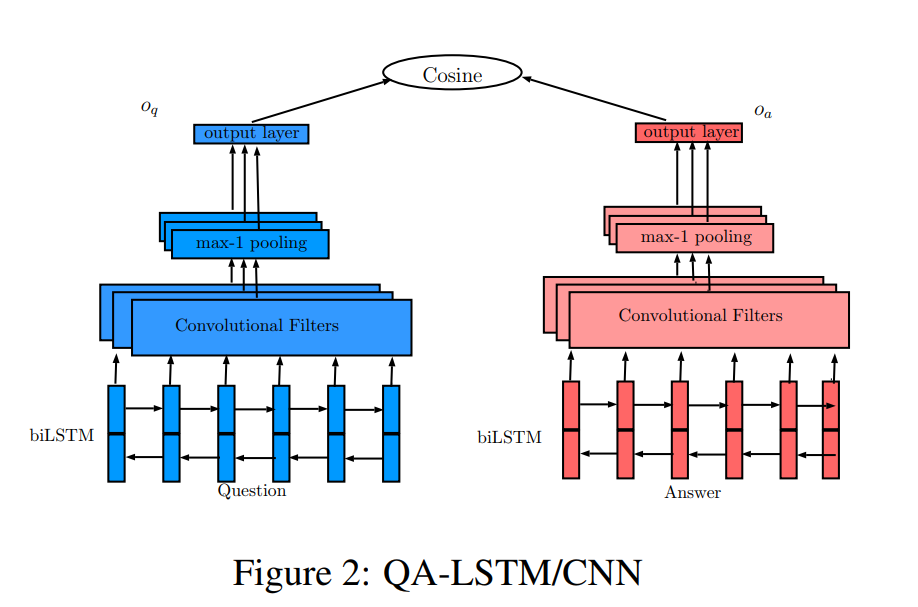

In [4]:
from IPython.display import Image
Image(filename='arc.png') 

我們之所以想要嘗試這個方法是因為這個方法把做 sentence embeddding 的工作交由 Bidirectional LSTM 實踐，我們認為會比原先直接把wordvector相加取平均的方法還要robust，具體的實作如下。


In [5]:
from __future__ import division, print_function
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Concatenate, Bidirectional
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import train_test_split
from keras.models import Model
from keras.layers import Input
import warnings
import numpy as np
import os
warnings.filterwarnings('ignore')

n_timesteps_in = 15
n_features = 300
def build_model():
    Q = Input(shape=(15, 300))
    A = Input(shape=(15, 300))
    
    x = Bidirectional(LSTM(100, return_sequences=True),input_shape=(n_timesteps_in, n_features))(Q)
    x = Convolution1D(150, 3, padding="same")(x)
    x = MaxPooling1D(pool_size=2, padding="same")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    
    y = Bidirectional(LSTM(100, return_sequences=True),input_shape=(n_timesteps_in, n_features))(A)
    y = Convolution1D(150, 3, padding="same")(y)
    y = MaxPooling1D(pool_size=2, padding="same")(y)
    y = Dropout(0.3)(y)
    y = Flatten()(y)
    
    #output = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x, y])
    merged = Concatenate()([x,y]) 
    output = Dense(2, activation="softmax")(merged)
    model = Model(inputs = [Q, A], outputs = [output], name="lstm_cnn")
    
    return model

model1 = build_model()
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15, 300)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 15, 300)      0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 15, 200)      320800      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 15, 200)      320800      input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (

這個架構與原先不同的是，input data 從一個代表整句的 sentence embeddding 變成一句話中每個字的 word vector，因此需要事先做 data preprocessing 做出符合 model 的 training/testing data

我們在 data preprocessing 時定義一句話的長度為15個字，因此一筆 training data 會是兩個長度為15的 word vector 分別餵進架構中的兩個 Bidirectional LSTM，如果這兩個句子相鄰，則將這組 training data 的 label 定義為 (1,0)，若不相鄰則定義為 (0,1)。我們分別做了數量相等的 (1,0), (0,1) 的training data，shuffle 後進行 training，Optimizer為 Adam ， Loss Function 為 Categorical Crossentropy

Testing時，如果一個句子的長度不滿15個字，就將該句子 padding 至等長並輸入 model 做 inference，由於每個句子對應到六個可能的答案，我們就分別將這六個可能的答案與該句子餵入model，最後取相似度最高的作為答案



## Disscusion

在 Gensim Package 內的 Word2Vec API，包括了以下幾個經常調動的參數：size、alpha、sg、window、workers、min_count、sample 以及 iter 等等。我們嘗試了調動 size、window 和 iter。我們試過以下幾種：
```python
1. model = word2vec.Word2Vec(doc, size=1024, window=5, min_count=5, iter=50)
2. model = word2vec.Word2Vec(doc, size=200, window=5, min_count=5, iter=50)
3. model = word2vec.Word2Vec(doc, size=250, window=5, min_count=5, iter=50)
4. model = word2vec.Word2Vec(doc, size=250, window=10, min_count=5, iter=15)
5. model = word2vec.Word2Vec(doc, size=250, window=15, min_count=5, iter=15)
6. model = word2vec.Word2Vec(doc, size=250, window=20, min_count=5, iter=15)
7. model = word2vec.Word2Vec(doc, size=250, window=25, min_count=5, iter=15)
8. model = word2vec.Word2Vec(doc, size=250, window=30, min_count=5, iter=15)
```
其中表現最好的是1.和7.，而3.~7.的accuracy有隨著window遞增而增加的趨勢，然而當window=30時，accuracy又下降了。

## Conclusion

本次競賽我們使用了 Word2Vec Embedding 與 RNN Encoder 兩種方法來構建所需要的 Word Embedding